In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [2]:
data=pd.read_csv("IMDB Dataset.csv")

In [3]:
len(data)

50000

In [4]:
data.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [5]:
data.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

# Подготовка данных

## Выбрасывание стоп-слов, стемминг, выбрасывание частых и редких слов

In [6]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Home/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
stemmer = nltk.stem.snowball.EnglishStemmer('english')

In [8]:
def data_Stemmer(text):
    return ' '.join([stemmer.stem(word) for word in text.split(' ') if word not in stop])

In [9]:
data.review = data.review.apply(lambda x: x.lower())

In [10]:
data.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. <br /><br />the...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive


In [11]:
data.review[1]

'a wonderful little production. <br /><br />the filming technique is very unassuming- very old-time-bbc fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />the actors are extremely well chosen- michael sheen not only "has got all the polari" but he has all the voices down pat too! you can truly see the seamless editing guided by the references to williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. a masterful production about one of the great master\'s of comedy and his life. <br /><br />the realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. it plays on our knowledge and our senses, particularly with the scenes concerning orton and halliwell and the sets (particularly of their flat with halliwell\'s murals decorating every surface) are terribly well d

In [12]:
data.review = data.review.apply(lambda x: data_Stemmer(x))

In [13]:
data.loc[data["sentiment"]=='positive',"sentiment"]=1
data.loc[data["sentiment"]=='negative',"sentiment"]=0

In [14]:
data["sentiment"]=data["sentiment"].astype("int32")

In [15]:
data.head()

,review,sentiment
0,one review mention watch 1 oz episod hooked. r...,1
1,wonder littl production. <br /><br />the film ...,1
2,thought wonder way spend time hot summer weeke...,1
3,basic there famili littl boy (jake) think ther...,0
4,"petter mattei ""love time money"" visual stun fi...",1


In [16]:
Xtrain, Xtest, Ytrain, Ytest=train_test_split(data["review"],data["sentiment"], test_size=0.3, random_state=42)

# Векторизация текстов при помощи tf-idf

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [18]:
TF_IDF = TfidfVectorizer(stop_words=stop, ngram_range=(1, 2), min_df=2, max_df=0.5, norm=None)

In [19]:
Xtrain_tfidf = TF_IDF.fit_transform(Xtrain)
Xtest_tfidf=TF_IDF.transform(Xtest)

# Классификация (лог. регрессия с кросс-валидацией)

In [20]:
from sklearn.linear_model import LogisticRegressionCV

In [21]:
LogRegCV=LogisticRegressionCV(Cs=[0.0001,0.005, 0.01, 0.05, 0.1,0.5,1.0,1.5,5.0,10.0,50.0,100.0,500.0,1000.0,10000.0],n_jobs=-1)

In [22]:
LogRegCV.fit(Xtrain_tfidf,Ytrain)

LogisticRegressionCV(Cs=[0.0001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 5.0,
                         10.0, 50.0, 100.0, 500.0, 1000.0, 10000.0],
                     class_weight=None, cv=None, dual=False, fit_intercept=True,
                     intercept_scaling=1.0, l1_ratios=None, max_iter=100,
                     multi_class='auto', n_jobs=-1, penalty='l2',
                     random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [23]:
Ypred=LogRegCV.predict(Xtest_tfidf)
Yprob=LogRegCV.predict_proba(Xtest_tfidf)

In [24]:
quality=pd.DataFrame(index=["Accuracy", "Precision", "Recall", "F1"])
def update_quality(qual,col_name, Ypr,Yt):
    qual[col_name]=0
    qual.loc["Accuracy", col_name]=accuracy_score(Ypr,Yt)
    qual.loc["Precision", col_name]=precision_score(Ypr,Yt)
    qual.loc["Recall", col_name]=recall_score(Ypr,Yt)
    qual.loc["F1", col_name]=f1_score(Ypr,Yt)

In [25]:
update_quality(quality,"LogReg common", Ypred, Ytest)

# Оценка качества классификации

In [26]:
quality

,LogReg common
Accuracy,0.905400
Precision,0.915140
Recall,0.899611
F1,0.907309


In [27]:
from sklearn.metrics import roc_auc_score, roc_curve

def plot_roc_curve(prob_prediction, actual):
    fpr, tpr, thresholds = roc_curve(actual, prob_prediction)
    auc_score = roc_auc_score(actual, prob_prediction)
    
    plt.plot(fpr, tpr, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC: {:.3f}'.format(auc_score))
    plt.show()

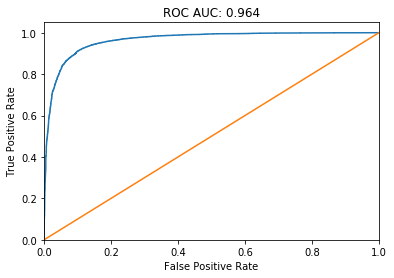

In [28]:
plot_roc_curve(Yprob[:,1],Ytest)

# Визуализация коэффициентов, наиболее характерные слова

In [29]:
def plot_positive_words(coef, feature_names, positive=True, n_top_features=50):
    if positive:
        Title="Characteristic words in positive"
        interesting_coefficients = np.argsort(coef)[-n_top_features:]
    else:
        Title="Characteristic words in negative"
        interesting_coefficients = np.argsort(coef)[:n_top_features]
    #interesting_coefficients = np.argsort(coef)[-n_top_features:]
    feature_names = np.array(feature_names)
    fn=np.reshape(feature_names[interesting_coefficients],-1)
    cf=coef[interesting_coefficients]
    wrddata=pd.DataFrame(index=fn)
    wrddata["K"]=cf
    plt.figure(figsize=(20,10))
    plt.xticks(rotation=60, ha="right",fontsize=18);
    plt.yticks(fontsize=18);
    wrddata["K"].plot(kind='bar', title=Title)

# Слова, характерные для положительных отзывов

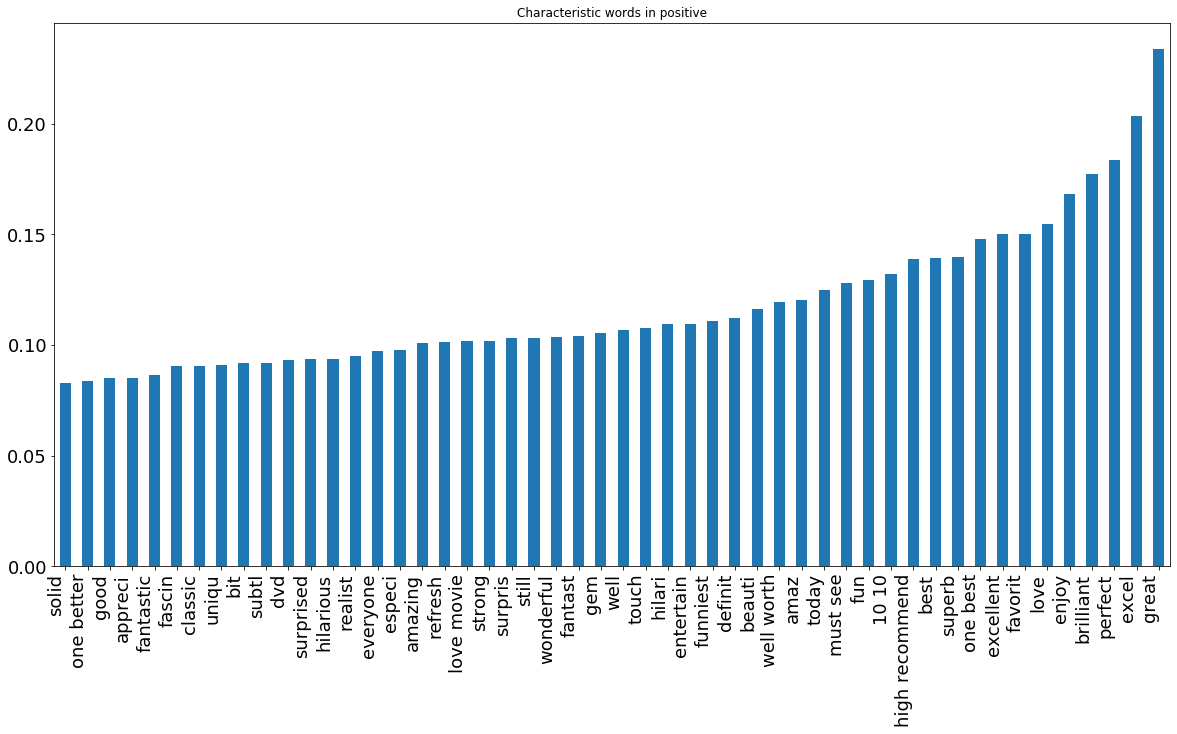

In [30]:
plot_positive_words(LogRegCV.coef_[0], TF_IDF.get_feature_names(), n_top_features=50)

### ...great, excellent, perfect, brilliant, enjoy, love...

# Слова, характерные для отрицательных отзывов

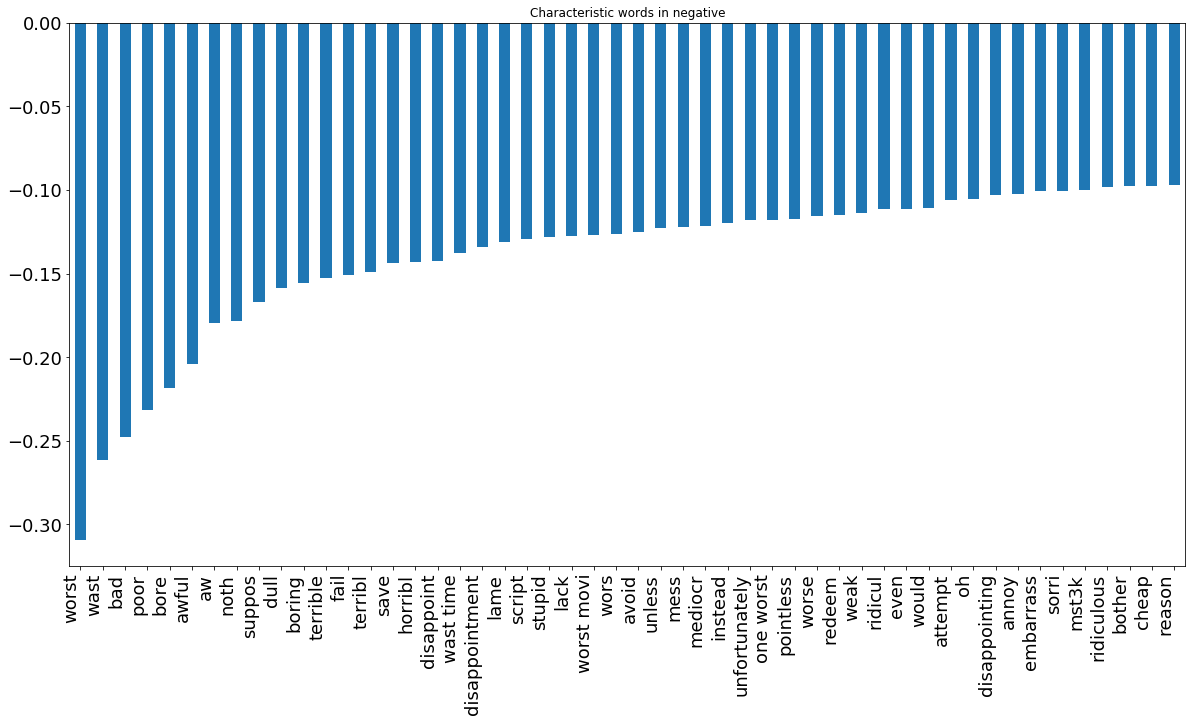

In [31]:
plot_positive_words(LogRegCV.coef_[0], TF_IDF.get_feature_names(), positive=False)

### ...worst, waste, bad, poor, boring, awfull...